<a href="https://colab.research.google.com/github/kinjal30/Image-Classification-with-TensorFlow-and-Keras/blob/main/AML_Assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

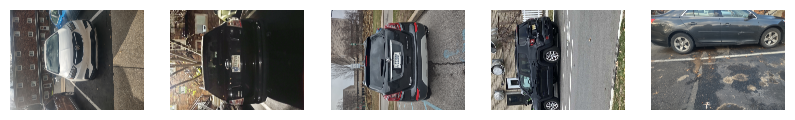

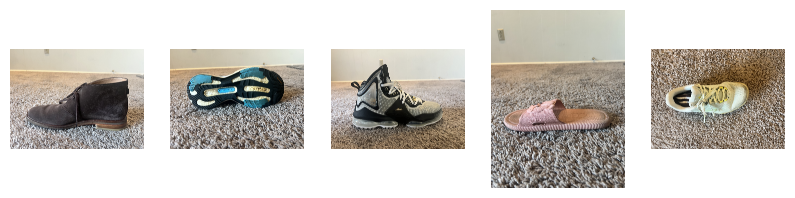

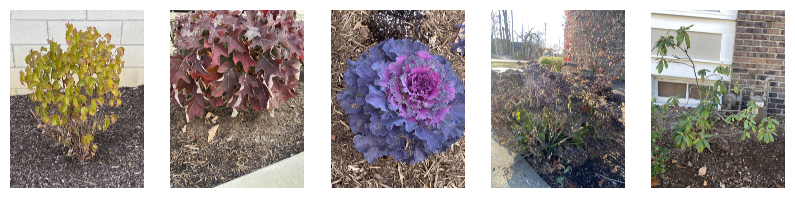

In [ ]:
import os
import random
import matplotlib.pyplot as plt

# Define the directories and classes
base_dir = "/content/drive/MyDrive/AML"
class_names = ["Cars","Footwear","trees"]

# Display 5 random images from each class
for class_name in class_names:
    class_dir = os.path.join(base_dir, class_name)
    image_names = os.listdir(class_dir)
    random.shuffle(image_names)
    plt.figure(figsize=(10,5))
    for i in range(5):
        img_path = os.path.join(class_dir, image_names[i])
        img = plt.imread(img_path)
        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        plt.axis("off")
    plt.show()

In [ ]:
import os
import shutil

# Define the directories and classes
base_dir = "/content/drive/MyDrive/AML"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")
class_names = ["Cars","Footwear","trees"]

# Create the directories
for dir in [train_dir, val_dir, test_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir, class_name))

# Split the images into the train, val, and test sets
for class_name in class_names:
    class_dir = os.path.join(base_dir, class_name)
    image_names = os.listdir(class_dir)
    random.shuffle(image_names)
    train_size = int(0.6 * len(image_names))
    val_size = int(0.2 * len(image_names))
    train_names = image_names[:train_size]
    val_names = image_names[train_size:train_size+val_size]
    test_names = image_names[train_size+val_size:]
    for name in train_names:
        src_path = os.path.join(class_dir, name)
        dst_path = os.path.join(train_dir, class_name, name)
        shutil.copy(src_path, dst_path)
    for name in val_names:
        src_path = os.path.join(class_dir, name)
        dst_path = os.path.join(val_dir, class_name, name)
        shutil.copy(src_path, dst_path)
    for name in test_names:
        src_path = os.path.join(class_dir, name)
        dst_path = os.path.join(test_dir, class_name, name)
        shutil.copy(src_path, dst_path)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data generators with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,           # rescale pixel values to [0, 1] range
    rotation_range=20,        # randomly rotate images by up to 20 degrees
    width_shift_range=0.1,    # randomly shift images horizontally by up to 10%
    height_shift_range=0.1,   # randomly shift images vertically by up to 10%
    shear_range=0.2,          # randomly apply shearing transformations
    zoom_range=0.2,           # randomly zoom in or out on images
    horizontal_flip=True,     # randomly flip images horizontally
    fill_mode='nearest'       # fill in missing pixels with the nearest available
)

val_datagen = ImageDataGenerator(
    rescale=1./255            # rescale pixel values to [0, 1] range
)

test_datagen = ImageDataGenerator(
    rescale=1./255            # rescale pixel values to [0, 1] range
)

# Set the batch size
batch_size = 32

# Define the train, validation, and test data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 236 images belonging to 3 classes.
Found 78 images belonging to 3 classes.
Found 81 images belonging to 3 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the input size of your images
IMG_SIZE = 224

# Define the number of classes in your dataset
NUM_CLASSES = 3

# Define the batch size for training and evaluation
BATCH_SIZE = 32

# Define the path to your dataset
DATA_DIR = "/content/drive/MyDrive/AML"


# Load the pre-trained ResNet50 model and replace the top layers for fine-tuning
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
predictions = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

# Freeze the base layers of the model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model with an optimizer, loss function, and evaluation metric
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model on the training data with the validation data for early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)
history = model.fit(train_generator, epochs=50, validation_data=val_generator, callbacks=[early_stopping])

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator)

print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

# Predict the classes of the test data and plot some examples of correct and incorrect predictions
import numpy as np
import matplotlib.pyplot as plt

preds = model.predict(test_generator)
predicted_classes = np.argmax(preds, axis=1)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

correct_indices = np.nonzero(predicted_classes == true_classes)[0]
incorrect_indices = np.nonzero(predicted_classes != true_classes)[0]

print('Number of correct predictions:', len(correct_indices))
print('Number of incorrect predictions:', len(incorrect_indices))

94765736/94765736 [==============================] - 1s 0us/step
Epoch 1/50
8/8 [==============================] - 135s 16s/step - loss: 2.1145 - accuracy: 0.3051 - val_loss: 1.8318 - val_accuracy: 0.5000
Epoch 2/50
8/8 [==============================] - 124s 17s/step - loss: 1.4330 - accuracy: 0.3517 - val_loss: 1.0626 - val_accuracy: 0.4487
Epoch 3/50
8/8 [==============================] - 124s 16s/step - loss: 1.1510 - accuracy: 0.4831 - val_loss: 1.0256 - val_accuracy: 0.5513
Epoch 4/50
8/8 [==============================] - 133s 17s/step - loss: 0.9623 - accuracy: 0.5975 - val_loss: 0.8705 - val_accuracy: 0.7179
Epoch 5/50
8/8 [==============================] - 122s 15s/step - loss: 0.8940 - accuracy: 0.6186 - val_loss: 0.7833 - val_accuracy: 0.6538
Epoch 6/50
8/8 [==============================] - 114s 14s/step - loss: 0.8264 - accuracy: 0.6992 - val_loss: 0.7558 - val_accuracy: 0.6923
Epoch 7/50
8/8 [==============================] - 123s 15s/step - loss: 0.8036 - accuracy: 0.75

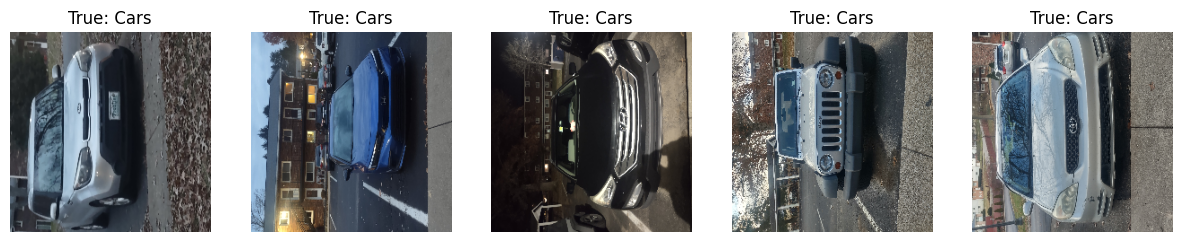

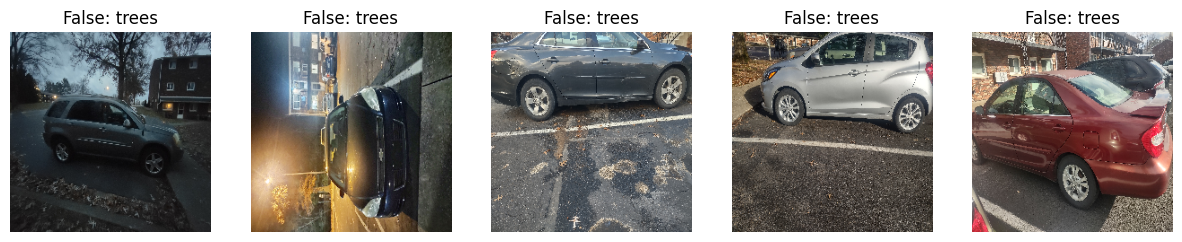

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# plot some correctly classified images
fig, axs = plt.subplots(1, 5, figsize=(15, 15))
axs = axs.flatten()
for i in range(5):
    idx = correct_indices[i]
    img_path = test_generator.filepaths[idx]
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMG_SIZE,IMG_SIZE))
    img = np.array(img)
    axs[i].imshow(img)
    axs[i].axis('off')
    true_class = class_names[true_classes[idx]]
    axs[i].set_title('True: {}'.format(true_class))



# plot some incorrectly classified images
fig, axs = plt.subplots(1, 5, figsize=(15, 15))
axs = axs.flatten()
for i in range(5):
    idx = incorrect_indices[i]
    img_path = test_generator.filepaths[idx]
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMG_SIZE,IMG_SIZE))
    img = np.array(img)
    axs[i].imshow(img)
    axs[i].axis('off')
    true_class = class_names[predicted_classes[idx]]
    axs[i].set_title('False: {}'.format(true_class))

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set up data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

# Load and prepare training and test datasets
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/AML/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/AML/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

# Define the model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    validation_data=validation_generator,
    validation_steps=len(validation_generator))

# Evaluate the model on the test set
test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/AML/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print('Test accuracy:', test_acc)

Found 236 images belonging to 3 classes.
Found 78 images belonging to 3 classes.
Epoch 1/50
8/8 [==============================] - 92s 11s/step - loss: 3.4657 - accuracy: 0.3983 - val_loss: 1.0880 - val_accuracy: 0.4487
Epoch 2/50
8/8 [==============================] - 88s 11s/step - loss: 1.0014 - accuracy: 0.5085 - val_loss: 0.9266 - val_accuracy: 0.4487
Epoch 3/50
8/8 [==============================] - 87s 11s/step - loss: 0.7894 - accuracy: 0.6314 - val_loss: 0.5381 - val_accuracy: 0.7692
Epoch 4/50
8/8 [==============================] - 86s 11s/step - loss: 0.7093 - accuracy: 0.7161 - val_loss: 0.4237 - val_accuracy: 0.8974
Epoch 5/50
8/8 [==============================] - 79s 10s/step - loss: 0.5063 - accuracy: 0.8220 - val_loss: 0.9718 - val_accuracy: 0.7564
Epoch 6/50
8/8 [==============================] - 85s 11s/step - loss: 0.2640 - accuracy: 0.9280 - val_loss: 0.2571 - val_accuracy: 0.8846
Epoch 7/50
8/8 [==============================] - 87s 11s/step - loss: 0.1933 - accur

3/3 [==============================] - 14s 4s/step


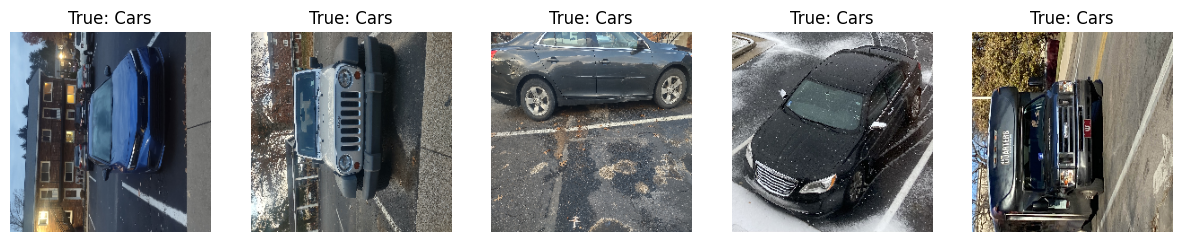

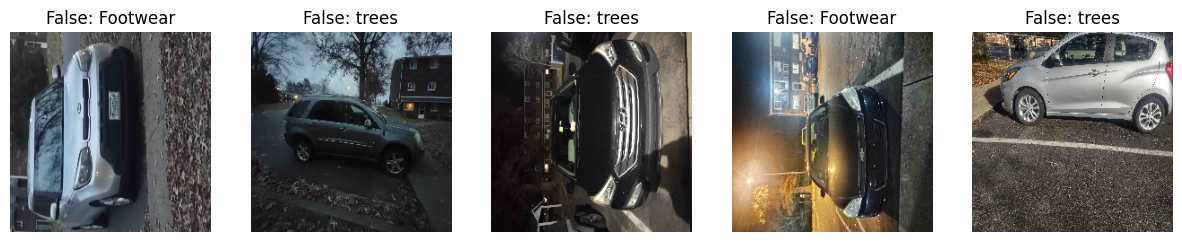

In [ ]:
batch_size = 32
img_height = 224
img_width = 224
num_classes = 3
import numpy as np
import matplotlib.pyplot as plt

preds = model.predict(test_generator)
predicted_classes = np.argmax(preds, axis=1)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())



correct_indices = np.where(predicted_classes == true_classes)[0]
incorrect_indices = np.where(predicted_classes != true_classes)[0]

# plot some correctly classified images
fig, axs = plt.subplots(1, 5, figsize=(15, 15))
axs = axs.flatten()
for i in range(5):
    idx = correct_indices[i]
    img_path = test_generator.filepaths[idx]
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_height, img_width))
    img = np.array(img)
    axs[i].imshow(img)
    axs[i].axis('off')
    true_class = class_names[true_classes[idx]]
    axs[i].set_title('True: {}'.format(true_class))

# plot some incorrectly classified images
fig, axs = plt.subplots(1, 5, figsize=(15, 15))
axs = axs.flatten()
for i in range(5):
    idx = incorrect_indices[i]
    img_path = test_generator.filepaths[idx]
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_height, img_width))
    img = np.array(img)
    axs[i].imshow(img)
    axs[i].axis('off')
    true_class = class_names[predicted_classes[idx]]
    axs[i].set_title('False: {}'.format(true_class))
